Import trick

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import numpy

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

# the real world
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astrocut import fits_cut
from astropy.nddata import Cutout2D

import pandas as pd

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

data

In [3]:
ddir = '../data/MAST_2024-07-11T09_26_05.575Z/'
fname_095 = ddir + 'HST/N43CA5020/n43ca5020_mos.fits'

fname_190 = ddir + 'HST/N43CA5010/n43ca5010_mos.fits'


wid = 80

exposure_095 = exposure_from_file(fname_095, wid)
exposure_190 = exposure_from_file(fname_190, wid)

exposures = [exposure_095, exposure_190]

models

In [4]:
oversample = 3

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

params = {
    "fluxes": {},
    "positions": {},
    "optics.cold_mask.transformation.translation": np.asarray([-0.05, -0.05]),
    "optics.cold_mask.transformation.rotation": np.pi/4,
    "optics.AberratedAperture.coefficients": np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9,
    "optics.cold_mask.outer.radius": 1.2*0.955,
    "optics.cold_mask.secondary.radius": 0.372*1.2,
    "optics.cold_mask.spider.width": 0.077*1.2,
}

for exp in exposures:
    params["positions"] = np.asarray([0.,0.])
    #params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.nansum(exp.data)

def set_array(pytree):
    dtype = np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

print(params)

model = set_array(NICMOSModel(exposures, params, optics, detector))

{'fluxes': {'N43CA5020': Array(6361.436, dtype=float32), 'N43CA5010': Array(30479.535, dtype=float32)}, 'positions': Array([0., 0.], dtype=float32), 'optics.cold_mask.transformation.translation': Array([-0.05, -0.05], dtype=float32), 'optics.cold_mask.transformation.rotation': 0.7853981633974483, 'optics.AberratedAperture.coefficients': Array([ 0.0000000e+00,  1.8000000e-08,  1.9400000e-08, -1.3999999e-09,
       -2.9999998e-09,  3.2999998e-09,  1.7000000e-09, -1.2199999e-08],      dtype=float32), 'optics.cold_mask.outer.radius': 1.146, 'optics.cold_mask.secondary.radius': 0.44639999999999996, 'optics.cold_mask.spider.width': 0.0924}


In [5]:

def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]

g = 1e-2

things_single = {
    "fluxes" : opt(g*10,10),
    "positions": opt(g*1, 0),
    "optics.cold_mask.transformation.translation": opt(g*10,100),
    "optics.cold_mask.transformation.rotation": opt(g*10,100),
    "optics.AberratedAperture.coefficients": opt(g*0.01,50),
    "optics.cold_mask.outer.radius": opt(g*10, 130),
    "optics.cold_mask.secondary.radius": opt(g*10,130),
    "optics.cold_mask.spider.width": opt(g*10,130),
    
}
groups_s = list(things_single.keys())
paths_s = flatten(groups_s)
optimisers_s = [things_single[i] for i in groups_s]
groups_s = [list(x) if isinstance(x, tuple) else x for x in groups_s]


In [6]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths_s)
def loss_fn_s(model,exposures):
    #return posterior(model,exposures[0])
    return np.nansum(np.asarray([posterior(model,exposure) for exposure in exposures]))

In [7]:
loss_fn_s(model, exposures)

(Array(73943856., dtype=float32),
 NICMOSModel(
   params={
     'fluxes':
     {'N43CA5010': f32[], 'N43CA5020': f32[]},
     'optics.AberratedAperture.coefficients':
     None,
     'optics.cold_mask.outer.radius':
     None,
     'optics.cold_mask.secondary.radius':
     None,
     'optics.cold_mask.spider.width':
     None,
     'optics.cold_mask.transformation.rotation':
     None,
     'optics.cold_mask.transformation.translation':
     None,
     'positions':
     f32[2]
   },
   filters={'F095N': None, 'F190N': None},
   optics=NICMOSOptics(
     wf_npixels=None,
     diameter=None,
     layers={
       'CompoundAperture':
       CompoundAperture(
         normalise=None,
         transformation=None,
         apertures={
           'cold_mask':
           NICMOSColdMask(
             normalise=None,
             transformation=CoordTransform(
               translation=f32[2],
               rotation=f32[],
               compression=None,
               shear=None
           

In [8]:
fishers_s = calc_fishers(model, exposures, paths_s, recalculate=False)
lrs_s = calc_lrs(model, exposures, fishers_s, paths_s)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[8.365787]]
[[4.1019616e+21 6.6776399e+20]
 [6.6776420e+20 3.4875504e+21]]
[[-1.5510354e+12  1.1679340e+12]
 [ 1.1679338e+12 -1.5078629e+12]]
[[-1.5807537e+12]]
[[-4.04144474e+21  1.25700603e+21  4.35160631e+20  2.20815346e+21
   9.49808458e+20 -6.26756038e+20  6.21211403e+20 -8.55076717e+20]
 [ 1.25702601e+21 -5.30446011e+21  8.94936248e+20  1.31325838e+21
   6.91454047e+20  8.25254795e+20 -1.93287389e+21  2.95676726e+20]
 [ 4.35160842e+20  8.94933293e+20 -6.77238814e+21 -1.62265652e+21
   6.76981940e+20  2.28487383e+21  5.85729055e+20  3.32896831e+20]
 [ 2.20808633e+21  1.31328174e+21 -1.62266088e+21 -2.76029956e+21
   1.43854351e+19  1.04652636e+21  4.37753332e+20  1.71269783e+21]
 [ 9.49806417e+20  6.91453554e+20  6.76983348e+20  1.43819837e+19
  -1.95691593e+21  2.43583959e+20 -7.07375890e+20  1.05554643e+21]
 [-6.26760964e+20  8.25262114e+20  2.28485975e+21  1.04652354e+21
   2.43580863e+20 -2.36395774e+21 -9.24277182e+19 -5.10792746e+20]
 [ 6.21233640e+20 -1.93290626e+21  5.857

  0%|          | 0/8 [00:00<?, ?it/s]

[[1.1325538]]
[[ 5.5721642e+21 -5.4723828e+19]
 [-5.4723912e+19  5.4252455e+21]]
[[-4.4264541e+11  3.3359997e+11]
 [ 3.3360003e+11 -4.3021314e+11]]
[[-4.4826808e+11]]
[[ 9.9186082e+19  5.0705170e+20 -2.6608667e+19  8.7537008e+20
   5.8922536e+20  1.1187408e+20  1.3129623e+20  1.9936540e+20]
 [ 5.0707295e+20 -3.7312196e+20  4.8348134e+19  5.6761301e+20
   3.6103817e+20  2.3569889e+20 -3.5564321e+20  2.8071658e+20]
 [-2.6603522e+19  4.8346173e+19 -2.9006492e+20 -7.7135550e+20
   3.4150025e+20  2.9661467e+20 -1.2023508e+20 -1.4296637e+19]
 [ 8.7536839e+20  5.6761195e+20 -7.7133805e+20  2.7617959e+21
   1.2659130e+19  7.8491394e+20  4.5923707e+19  1.4921777e+20]
 [ 5.8922336e+20  3.6103817e+20  3.4150043e+20  1.2659282e+19
   3.0773924e+21  3.5079857e+19 -6.1880993e+20 -7.0572841e+18]
 [ 1.1187324e+20  2.3569861e+20  2.9661819e+20  7.8491394e+20
   3.5080270e+19  3.1394596e+21 -4.6486416e+20  2.4916088e+19]
 [ 1.3129896e+20 -3.5564472e+20 -1.2023506e+20  4.5921086e+19
  -6.1882344e+20 -4.6

In [9]:
optim_s, opt_state_s = zdx.get_optimiser(
    model, groups_s, optimisers_s
)


losses_s, models_s = [], []
for i in tqdm(range(200)):
    loss, grads = loss_fn_s(model,exposures)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, lrs_s)
    updates, opt_state_s = optim_s.update(grads, opt_state_s)
    model = zdx.apply_updates(model, updates)

    models_s.append(model)
    losses_s.append(loss)

  0%|          | 0/200 [00:00<?, ?it/s]

In [10]:
losses_s[-1]/losses_s[0]

Array(8.875043, dtype=float32)

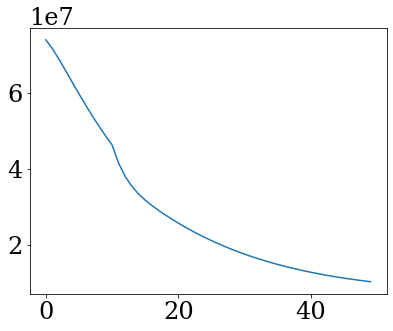

In [14]:
plt.plot(losses_s[:50])

In [12]:
model.params

{'fluxes': {'N43CA5010': Array(31438.668, dtype=float32),
  'N43CA5020': Array(5666.365, dtype=float32)},
 'optics.AberratedAperture.coefficients': Array([ 0.0000000e+00,  1.8000000e-08,  1.9400000e-08, -1.3999999e-09,
        -2.9999998e-09,  3.2999998e-09,  1.7000000e-09, -1.2199999e-08],      dtype=float32),
 'optics.cold_mask.outer.radius': Array(1.146, dtype=float32),
 'optics.cold_mask.secondary.radius': Array(0.4464, dtype=float32),
 'optics.cold_mask.spider.width': Array(0.0924, dtype=float32),
 'optics.cold_mask.transformation.rotation': Array(0.7853982, dtype=float32),
 'optics.cold_mask.transformation.translation': Array([-0.05, -0.05], dtype=float32),
 'positions': Array([-4.009783e-08,  7.444661e-08], dtype=float32)}

optimisers

In [8]:

def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]

g = 1e-2

things_single = {
    "fluxes" : opt(g*10,10),
    "positions": opt(g*1, 0),
    "cold_mask.transformation.translation": opt(g*10,100),
    "cold_mask.transformation.rotation": opt(g*10,100),
    "AberratedAperture.coefficients": opt(g*1,50),
    "cold_mask.outer.radius": opt(g*10, 130),
    "cold_mask.secondary.radius": opt(g*10,130),
    "cold_mask.spider.width": opt(g*10,130),
}

g = 2e-2

things_binary = {
    "mean_flux" : opt(g*10,10),
    "position": opt(g*1, 0),
    "separation": opt(g*1, 20),
    "contrast": opt(g*1, 20),
    "position_angle": opt(g*1, 20),
    "cold_mask.transformation.translation": opt(g*100,100),
    "cold_mask.transformation.rotation": opt(g*100,100),
    "AberratedAperture.coefficients": opt(g*1,50),
    "cold_mask.outer.radius": opt(g*10, 130),
    "cold_mask.secondary.radius": opt(g*10,130),
    "cold_mask.spider.width": opt(g*10,130),
}

groups_s = list(things_single.keys())
paths_s = flatten(groups_s)
optimisers_s = [things_single[i] for i in groups_s]
groups_s = [list(x) if isinstance(x, tuple) else x for x in groups_s]

groups_b = list(things_binary.keys())
paths_b = flatten(groups_b)
optimisers_b = [things_binary[i] for i in groups_b]
groups_b = [list(x) if isinstance(x, tuple) else x for x in groups_b]

In [9]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths_s)
def loss_fn_s(model,exposure):
    return posterior(model,exposure)

@zdx.filter_jit
@zdx.filter_value_and_grad(paths_b)
def loss_fn_b(model,exposure):
    return posterior(model,exposure)

In [10]:
#fishers_s = calc_fishers(array_model_s, [exposure_190], paths_s, recalculate=rc)
#lrs_s = calc_lrs(array_model_s, [exposure_190], fishers_s, paths_s)

#fishers_b = calc_fishers(array_model_b, [exposure_190], paths_b, recalculate=rc)
#lrs_b = calc_lrs(array_model_b, [exposure_190], fishers_b, paths_b)

In [11]:
optim_s, opt_state_s = zdx.get_optimiser(
    point_model, groups_s, optimisers_s
)


losses_s, models_s = [], []
for i in tqdm(range(200)):
    loss, grads = loss_fn_s(point_model,exposure_190)
    #grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, lrs_s)
    updates, opt_state_s = optim_s.update(grads, opt_state_s)
    point_model = zdx.apply_updates(point_model, updates)

    models_s.append(point_model)
    losses_s.append(loss)

optim_b, opt_state_b = zdx.get_optimiser(
    binary_model, groups_b, optimisers_b
)


losses_b, models_b = [], []
for i in tqdm(range(200)):
    loss, grads = loss_fn_b(binary_model,exposure_190)
    #grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, lrs_b)
    updates, opt_state_b = optim_b.update(grads, opt_state_b)
    binary_model = zdx.apply_updates(binary_model, updates)

    models_b.append(binary_model)
    losses_b.append(loss)

NameError: name 'point_model' is not defined

In [ ]:
print(losses_s[0], losses_s[-1])
print(losses_b[0], losses_b[-1])


380988450.0 687160.3
352666660.0 578522.44


In [ ]:
for g in groups_s:
    if type(g) == list:
        for s in g:
            print(s, point_model.get(s))
    else:
        print(g, point_model.get(g))

print()

for g in groups_b:
    if type(g) == list:
        for s in g:
            print(s, binary_model.get(s))
    else:
        print(g, binary_model.get(g))

flux 31543.518
position [-6.4532358e-08  9.6446854e-08]
cold_mask.transformation.translation [-0.05022504 -0.05020903]
cold_mask.transformation.rotation 0.7854063
AberratedAperture.coefficients [ 7.6747927e-11  5.1741051e-08  1.0226233e-08 -3.9083091e-08
  1.8550836e-08  1.5261922e-08 -5.6058458e-10 -5.4977853e-09]
cold_mask.outer.radius 1.1447636
cold_mask.secondary.radius 0.44679445
cold_mask.spider.width 0.09331713

mean_flux 15925.974
position [6.711045e-09 9.219978e-08]
separation 1.7960154e-07
contrast 0.11210773
position_angle 1.5645667
cold_mask.transformation.translation [-0.05099856 -0.0523611 ]
cold_mask.transformation.rotation 0.7853994
AberratedAperture.coefficients [ 6.2631839e-10  5.6263527e-08  1.7171871e-09 -3.7169070e-08
  1.9851489e-08  1.5490270e-08 -1.4554017e-09  2.2118123e-11]
cold_mask.outer.radius 1.1449351
cold_mask.secondary.radius 0.44802415
cold_mask.spider.width 0.09198713


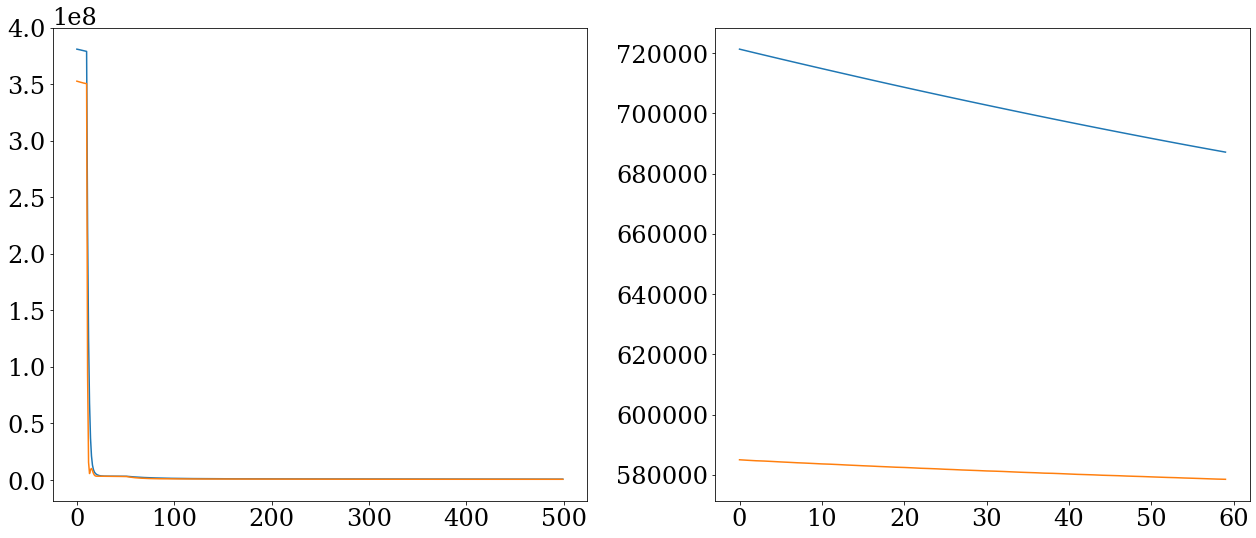

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(18,8))
axs[0].plot(losses_s)
axs[1].plot(losses_s[-60:])
axs[0].plot(losses_b)
axs[1].plot(losses_b[-60:])
fig.tight_layout()

39.59195 40.45005


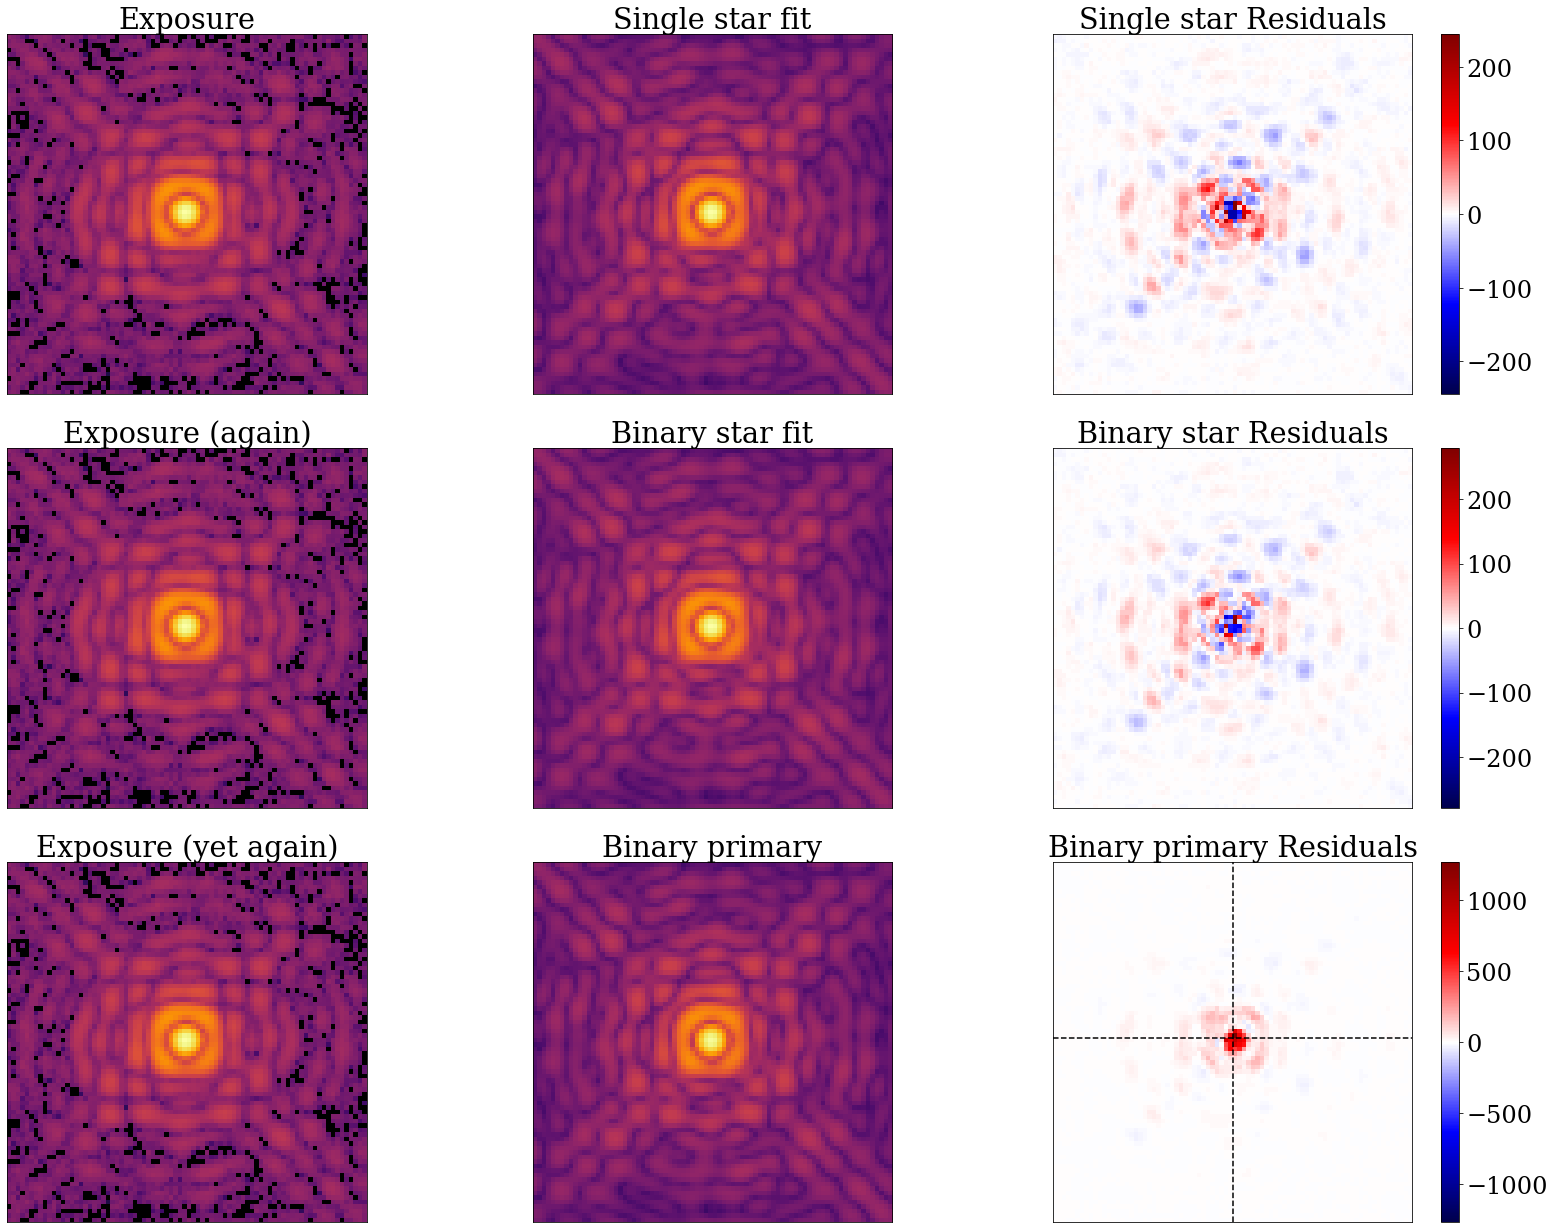

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(30*0.8,22*0.8))


cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exposure.data**0.125

point_frame = point_model.model()**0.125
binary_frame = binary_model.model()**0.125

single_resid = (exposure.data-point_model.model())/exposure.err
binary_resid = (exposure.data-binary_model.model())/exposure.err

vm = max(np.nanmax(cropped_frame),np.nanmax(point_frame), np.nanmax(binary_frame))


axs[0,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[0,1].imshow(point_frame,cmap=cmap, vmin=0, vmax=vm)
rlim = np.nanmax(np.abs(single_resid))
resid = axs[0,2].imshow(single_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[0,2])

axs[1,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[1,1].imshow(binary_frame,cmap=cmap, vmin=0, vmax=vm)

rlim = np.nanmax(np.abs(binary_resid))
resid = axs[1,2].imshow(binary_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[1,2])

binary_primary_source = dl.PointSource(
    spectrum=dl.Spectrum(wavels_190,weights_190),
    position = dlu.positions_from_sep(
        binary_model.position,
        binary_model.separation,
        binary_model.position_angle
    )[1],
    flux = dlu.fluxes_from_contrast(
        binary_model.mean_flux,
        binary_model.contrast
    )[1]
)

binary_primary_system = dl.Telescope(
    binary_model.optics,
    binary_primary_source,
    binary_model.detector
)

binary_primary_frame = binary_primary_system.model()**0.125

axs[2,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[2,1].imshow(binary_primary_frame,cmap=cmap, vmin=0, vmax=vm)

bp_resid = (exposure.data-binary_primary_system.model())/exposure.err
rlim = np.nanmax(np.abs(bp_resid))
resid = axs[2,2].imshow(bp_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[2,2])

x, y = dlu.rad2arcsec(binary_primary_system.position)/0.042 + wid/2

print(x,y)

axs[2,2].axvline(x, color='k',linestyle='--')
axs[2,2].axhline(y, color='k',linestyle='--')

axs[0,0].set_title("Exposure")
axs[1,0].set_title("Exposure (again)")
axs[2,0].set_title("Exposure (yet again)")

axs[0,1].set_title("Single star fit")
axs[1,1].set_title("Binary star fit")
axs[2,1].set_title("Binary primary")

axs[0,2].set_title("Single star Residuals")
axs[1,2].set_title("Binary star Residuals")
axs[2,2].set_title("Binary primary Residuals")



for i in range(3):
    for j in range(3):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

fig.tight_layout()


8
flux
position
cold_mask.transformation.translation
cold_mask.transformation.rotation
AberratedAperture.coefficients
cold_mask.outer.radius
cold_mask.secondary.radius
cold_mask.spider.width


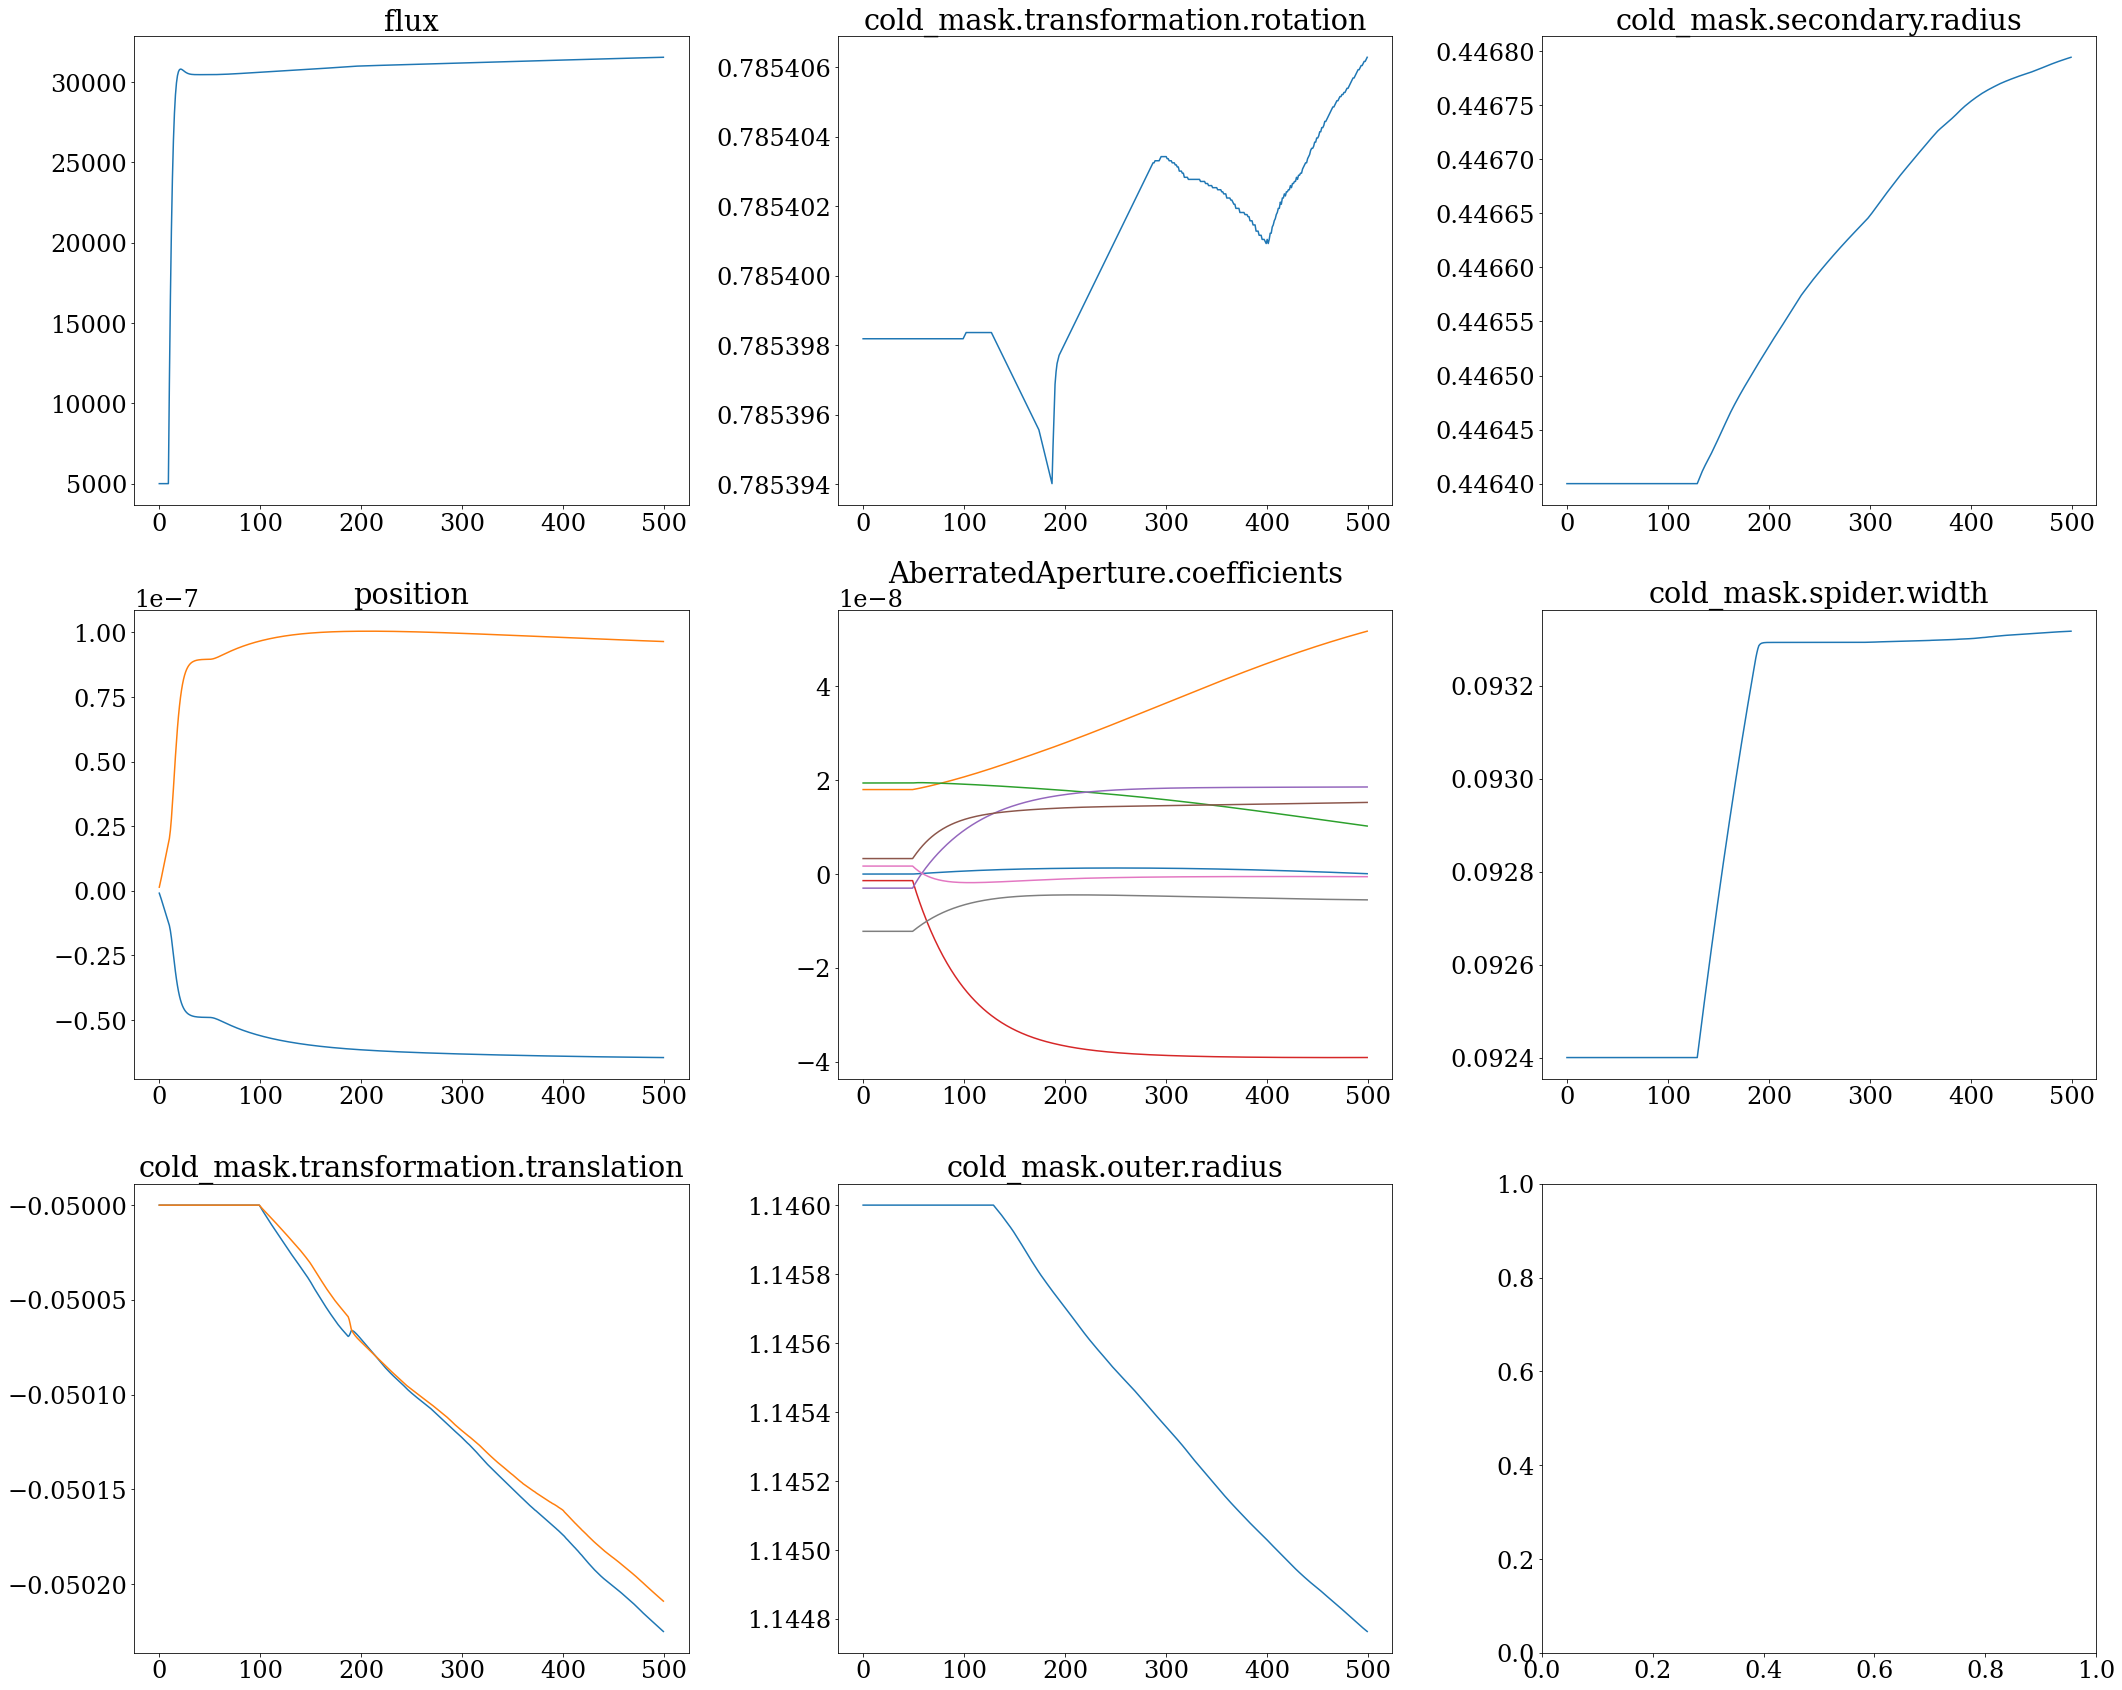

In [ ]:
xw = 3
yw = int(np.ceil(len(groups_s)/xw))

print(len(groups_s))

fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups_s):
    print(param)
    sp = axs[i%xw, i//xw]
    if type(param) == list:
        sp.set_title(f"{param[0]} ...")
        for p in param:
            sp.plot([x.get(p) for x in models_s])
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models_s])
    
fig.tight_layout()

11
mean_flux
position
separation
contrast
position_angle
cold_mask.transformation.translation
cold_mask.transformation.rotation
AberratedAperture.coefficients
cold_mask.outer.radius
cold_mask.secondary.radius
cold_mask.spider.width


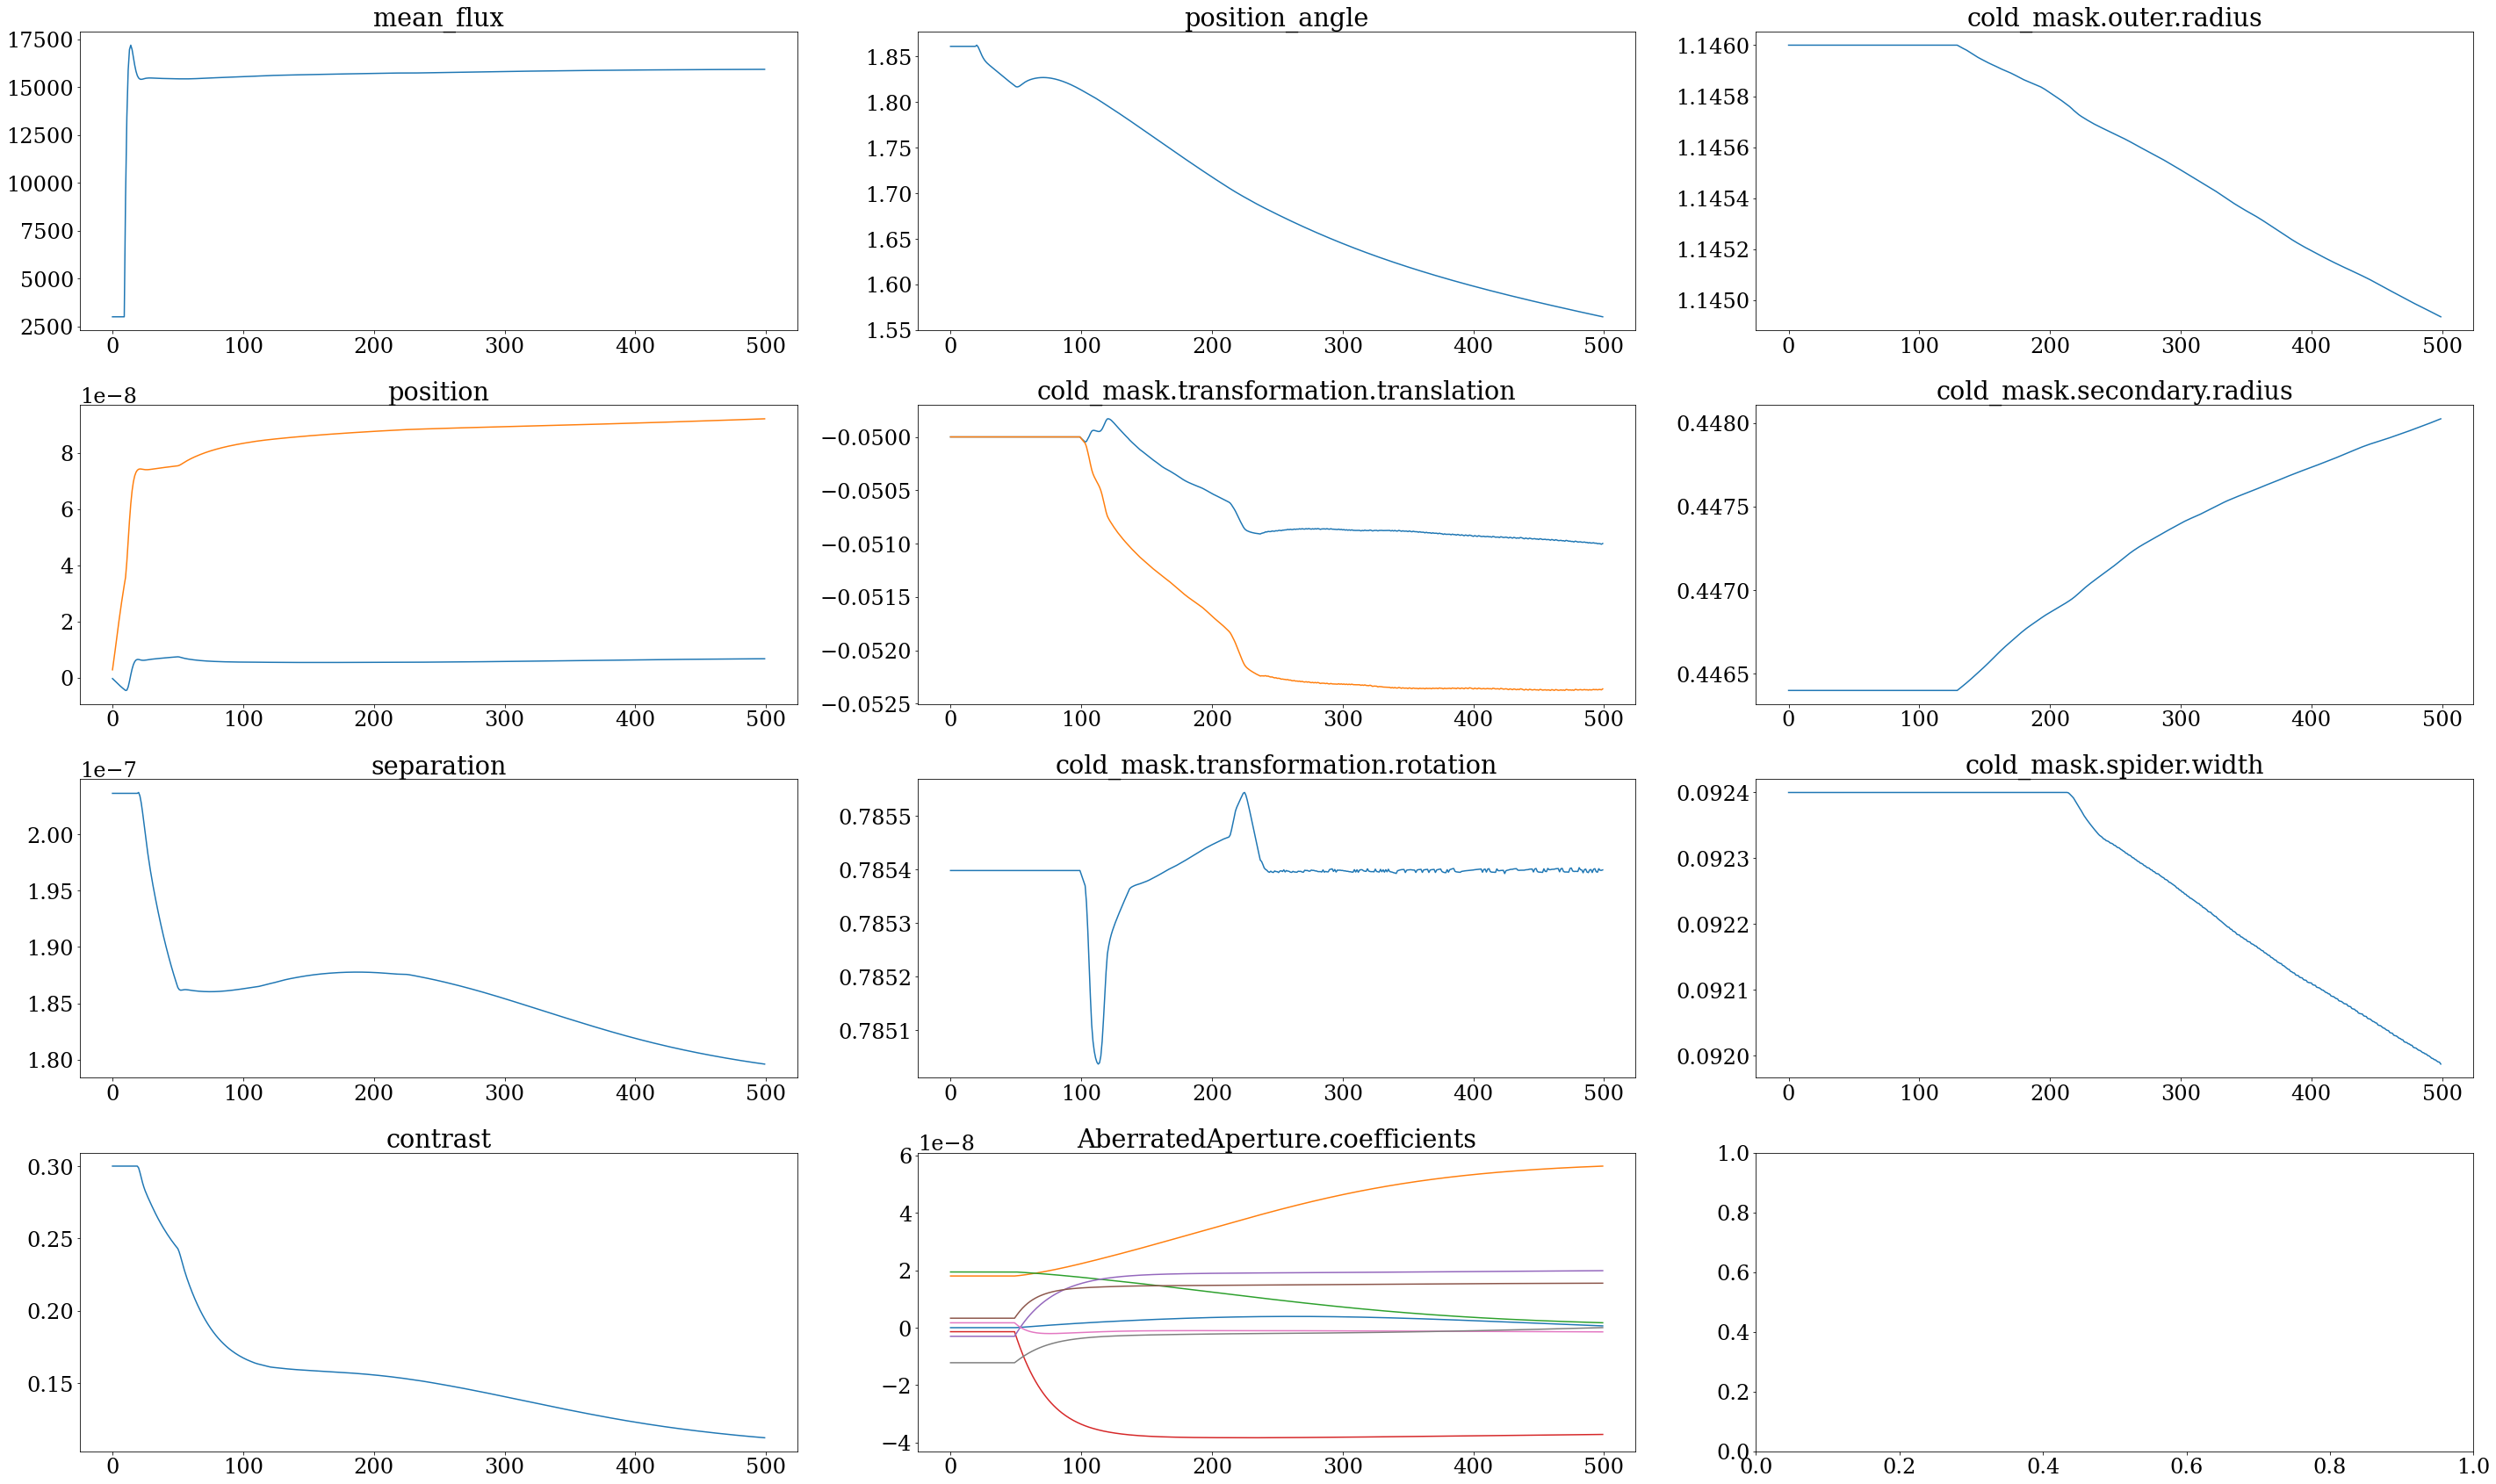

In [ ]:
xw = 4
yw = int(np.ceil(len(groups_b)/xw))

print(len(groups_b))

fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups_b):
    print(param)
    sp = axs[i%xw, i//xw]
    if type(param) == list:
        sp.set_title(f"{param[0]} ...")
        for p in param:
            sp.plot([x.get(p) for x in models_b])
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models_b])
    
fig.tight_layout()